# Node Degree

## Load dependencies

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from lib.dictionaries import read_dictionary_one_to_set
import re
import dataframe_image as dfi
from statistics import median, mean
import visualization.visualize_single_network as v
import networkx as nx

import config
from config import LEVELS, INTERACTOMES_PATH, METHODS, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH, genes, proteins, proteoforms, COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL
from lib.networks import get_interactomes, get_combinations, get_combinations_with_pathways
from lib.networks import get_multiindex, get_sizes, get_json_filename, create_pathway_interaction_network, read_graph, \
    get_pathways_with_multiple_proteoforms, get_increase_percentage, create_pathway_interaction_networks
from lib.graph_database_access import get_pathways
from queries import QUERY_GET_PATHWAYS_BY_PROTEIN
from lib.graph_database_access import get_query_result

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: c:\git\ProteoformNetworks


# Degree by Interactomes

## Load interactomes

In [2]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [interactomes_no_sm[genes], interactomes_no_sm[proteoforms], interactomes_with_sm[genes], interactomes_with_sm[proteoforms], interactomes_with_unique_sm[genes], interactomes_with_unique_sm[proteoforms]]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteins level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteins level, 

## Degree of all proteoforms and its genes

In [3]:
map_proteins_to_genes = read_dictionary_one_to_set(INTERACTOMES_PATH, "mapping_proteins_to_genes.tsv", col_indices=(0, 1))
map_proteins_to_genes
proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm[proteoforms].degree()]
proteoform_degrees

df_degrees_genes_vs_all_proteoforms = pd.DataFrame(proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_all_proteoforms["Gene"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_all_proteoforms["Gene Degree"] = df_degrees_genes_vs_all_proteoforms["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_all_proteoforms["Annotations"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
df_degrees_genes_vs_all_proteoforms

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
0,P08887-2;,25,IL6R,15,True
1,P05231;,264,IL6,149,False
2,O60674;,166,JAK2,175,False
3,P23458;,143,JAK1,154,False
4,P29597;,86,TYK2,93,False
...,...,...,...,...,...
14241,Q9UN19;00048:139,2,DAPP1,1,True
14242,P40259;,68,CD79B,80,False
14243,P11912;,68,CD79A,80,False
14244,"P06241;00068:2,00115:3,00115:6",67,FYN,297,True


## Plot degree distribution in the interactomes

In [4]:
degree_sequences = []
for interactome in interactomes:            
    accessioned_nodes = [node for node, data in interactome.nodes(data=True) if not data['type'].startswith("Simple")]
    sequence = sorted([d for n, d in interactome.degree(accessioned_nodes)], reverse=True)
    degree_sequences.append(sequence)

degree_sequences = pd.Series(degree_sequences, index=index)
degree_sequences

Small Molecules           Entity Level
Not Included              genes           [1243, 1220, 1059, 1059, 586, 579, 540, 530, 5...
                          proteoforms     [1474, 1449, 1284, 1284, 627, 619, 606, 604, 6...
Included                  genes           [1290, 1267, 1103, 1103, 765, 754, 645, 642, 6...
                          proteoforms     [1520, 1495, 1327, 1327, 780, 762, 747, 720, 7...
Reaction-Unique Included  genes           [2361, 2331, 1989, 1806, 1766, 1556, 1556, 153...
                          proteoforms     [2376, 2339, 2029, 1997, 1987, 1773, 1773, 153...
dtype: object

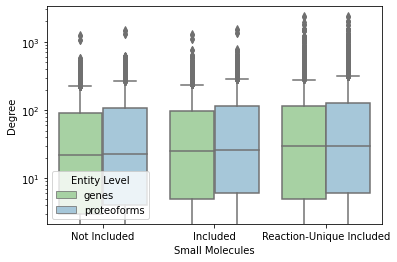

In [5]:
df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes.png')

In [6]:
degrees_genes = degree_sequences["Included", "genes"]
degrees_proteoforms = degree_sequences["Included", "proteoforms"]
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms))
print(f"the degree in the complete proteoform network is increased in average from {mean(degrees_genes)} to {mean(degrees_proteoforms)} connections ({change} %)")

the degree in the complete proteoform network is increased in average from 72.88073979591837 to 88.06310543310403 connections (29.79 %)


## Degree of proteoforms with annotations

In [7]:
proteoforms_no_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
proteoforms_with_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

modified_proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm["proteoforms"].degree(proteoforms_with_annotations)]

df_degrees_genes_vs_proteoforms_with_annotations = pd.DataFrame(modified_proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_proteoforms_with_annotations["Gene"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_proteoforms_with_annotations["Gene Degree"] = df_degrees_genes_vs_proteoforms_with_annotations["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_proteoforms_with_annotations["Annotations"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
dfi.export(df_degrees_genes_vs_proteoforms_with_annotations.set_index("Proteoform").sample(20), 'figures/df_degrees_genes_vs_modified_proteoforms.png')
df_degrees_genes_vs_proteoforms_with_annotations.sample(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
3367,O14867;01148:null,10,BACH1,12,True
1059,P84243;00064:10,61,H3-3A,231,True
1495,"P04114;00028:680,00028:883,00028:2665,00028:28...",17,APOB,276,True
1527,"Q9UHD2;00046:172,01148:670",10,TBK1,46,True
1612,P68431;00077:3,8,H3C1,348,True
828,"P02461;00038:null,00039:null,00162:null",540,COL3A1,67,True
181,"P08581;00048:1234,00048:1235,00048:1349,00048:...",150,MET,138,True
2023,P04150-3;,85,NR3C1,84,True
1572,Q71DI3;00064:15,156,H3C15,343,True
1585,P62805;00064:17,126,H4C1,406,True


In [8]:
degrees_proteoforms_with_annotations = df_degrees_genes_vs_proteoforms_with_annotations["Proteoform Degree"]
print(f"Selected {len(degrees_proteoforms_with_annotations)} unique proteoforms.")
degrees_genes = df_degrees_genes_vs_proteoforms_with_annotations.drop_duplicates(subset= ["Gene"])["Gene Degree"]
print(f"Selected {len(degrees_genes)} unique genes.")
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms_with_annotations))
print(f"the degree of annotated proteoform nodes in the complete proteoform network changes from {mean(degrees_genes)} to {mean(degrees_proteoforms_with_annotations)} connections ({change} %)")

Selected 3433 unique proteoforms.
Selected 1691 unique genes.
the degree of annotated proteoform nodes in the complete proteoform network changes from 83.89000591366056 to 113.1421497232741 connections (103.02 %)


## Plot degree of proteoforms with annotations

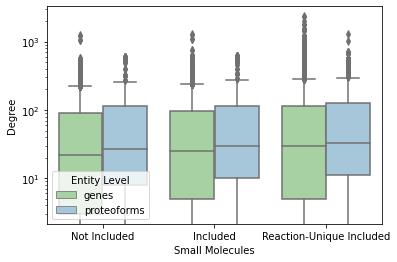

In [9]:
# The interactoms are 0: no_sm-genes, 1: no_sm-proteoforms, 2: with_sm-genes, 3: with_sm-proteoforms, 4: with_unique_sm-genes, 5: with_unique_sm-proteoforms
for i in [1, 3, 5]:
    degree_sequences[i] = [degree for proteoform_node, degree in interactomes[i].degree(proteoforms_with_annotations)]

degree_sequences = pd.Series(degree_sequences, index=index)

df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes_proteoforms_with_annotations.png')

## Count proteoforms with higher or lower degree than genes

In [10]:
def getChange(value):
    if value > 0: return "+"
    elif value == 0: return "="
    else: return "-"

df_degrees_genes_vs_all_proteoforms["Degree Difference"] = df_degrees_genes_vs_all_proteoforms["Proteoform Degree"] - df_degrees_genes_vs_all_proteoforms["Gene Degree"]
df_degrees_genes_vs_all_proteoforms["Change"] = df_degrees_genes_vs_all_proteoforms["Degree Difference"].apply(lambda d: getChange(d))
df_degrees_genes_vs_all_proteoforms

print(f"For all proteoforms: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.groupby(['Change']).size(), columns=["Count"])

df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms) * 100
print(df_cases)

print(f"For proteoforms with annotations: ")
cases = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True].groupby(['Change']).size()
df_cases = pd.DataFrame(cases, columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]) * 100
print(df_cases)

print(f"For proteoforms no annotations: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False].groupby(['Change']).size(), columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]) * 100
print(df_cases)

For all proteoforms: 
        Count  Percentage
Change                   
+        4979       34.95
-        2688       18.87
=        6579       46.18
For proteoforms with annotations: 
        Count  Percentage
Change                   
+        1227       35.74
-        1960       57.09
=         246        7.17
For proteoforms no annotations: 
        Count  Percentage
Change                   
+        3752       34.70
-         728        6.73
=        6333       58.57


## Examples of proteoforms that have higher degree than gene nodes

In [11]:
df_degrees_genes_vs_all_proteoforms.sort_values(by = "Degree Difference").tail(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations,Degree Difference,Change
2857,Q9P218;00039:null,538,COL20A1,58,True,480,+
2832,Q02388;,601,COL7A1,121,False,480,+
2803,P12110;00039:null,546,COL6A2,66,True,480,+
2807,P12109;00039:null,546,COL6A1,66,True,480,+
2810,P12111;00039:null,546,COL6A3,66,True,480,+
2812,A8TX70;00039:null,546,COL6A5,66,True,480,+
2814,A6NMZ7;00039:null,546,COL6A6,66,True,480,+
1737,Q99715;00039:null,539,COL12A1,59,True,480,+
2846,P12107;00039:null,546,COL11A1,66,True,480,+
2848,P02458;00039:null,546,COL2A1,66,True,480,+


## Example of how the degree of some proteoforms increases

In [12]:
gene = "COL7A1"
protein = "Q02388"

# Get pathways in which gene X participates
pathways = get_query_result(QUERY_GET_PATHWAYS_BY_PROTEIN.replace("identifier:\"\"", f"identifier:\"{protein}\""))
pathway = "R-HSA-8934903"
# Check plots at gene and proteoform level

graphs = create_pathway_interaction_networks(pathway, config.PATHWAY_GRAPHS_PATH)
graphs
list(graphs[config.with_unique_sm][proteoforms].nodes())

m = nx.get_node_attributes(graphs[config.with_unique_sm][proteoforms], "gene")
# m['P67870;']
m

{'P67870;': 'CSNK2B',
 'P19784;': 'CSNK2A2',
 'P68400;': 'CSNK2A1',
 'Q8IVP5;': 'FUNDC1',
 'Q8IVP5;00046:13': 'FUNDC1',
 'O75385;': 'ULK1',
 'Q96HS1-2;': 'PGAM5',
 'P12931-1;': 'SRC',
 'Q8IVP5;00046:13,00048:18': 'FUNDC1',
 'Q8IVP5;00046:17': 'FUNDC1',
 'Q9H1Y0;': 'ATG5',
 'O94817;': 'ATG12',
 'Q9GZQ8;': 'MAP1LC3B',
 'Q9H492;': 'MAP1LC3A'}

In [13]:

nx.get_node_attributes(graphs[config.no_sm][config.proteoforms], "prevId")

p = v.plot_pathway_all_levels(pathway, out_path=PATHWAY_GRAPHS_PATH, graphs=graphs,
                                coloring=v.Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size=12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location=None)

Processing node P67870;
Processing node P19784;
Processing node P68400;
Processing node Q8IVP5;
Processing node Q8IVP5;00046:13
Processing node O75385;
Processing node Q96HS1-2;
Processing node P12931-1;
Processing node Q8IVP5;00046:13,00048:18
Processing node Q8IVP5;00046:17
Processing node Q9H1Y0;
Processing node O94817;
Processing node Q9GZQ8;
Processing node Q9H492;
Plotting network for genes
with method: no_sm
Plotting network for proteoforms
with method: no_sm
Plotting network for genes
with method: with_sm
Plotting network for proteoforms
with method: with_sm
Plotting network for genes
with method: with_unique_sm
Plotting network for proteoforms
with method: with_unique_sm
Generated figure: networks/pathways/R-HSA-8934903_ENTITY_TYPE_network.html


## Plot degree of all proteoforms compared to gene degree

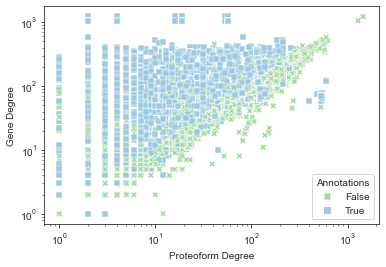

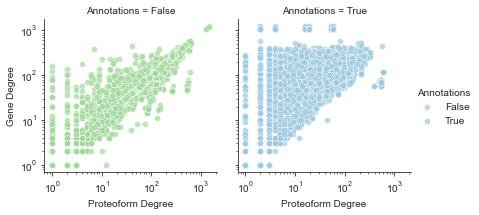

In [14]:
markers = {True: "s", False: "X"}
sns.set_style("ticks")
plot = sns.scatterplot(data=df_degrees_genes_vs_all_proteoforms, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

plot = sns.FacetGrid(df_degrees_genes_vs_all_proteoforms, col="Annotations", hue="Annotations", palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.map(sns.scatterplot, "Proteoform Degree", "Gene Degree", alpha=.7, markers=markers)
plot.add_legend()
for ax in plot.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
plot.set(xscale="log", yscale="log")


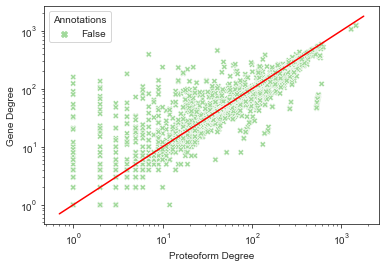

In [15]:
# Plot proteoform vs gene degree for non annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]

plot = sns.scatterplot(data=df, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

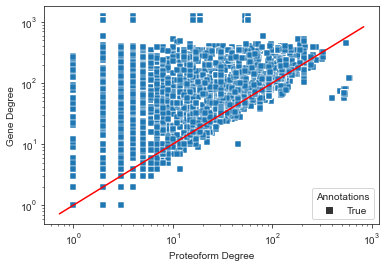

In [16]:
# Plot proteoform vs gene degree for annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]
plot = sns.scatterplot(data=df_degrees_genes_vs_proteoforms_with_annotations, x="Proteoform Degree", y="Gene Degree", style="Annotations", markers=markers, palette=[COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

## Degree with small molecules

In [17]:
# The interactoms are 0: no_sm-genes, 1: no_sm-proteoforms, 2: with_sm-genes, 3: with_sm-proteoforms, 4: with_unique_sm-genes, 5: with_unique_sm-proteoforms

degree_gene_nodes_no_sm = list((d for n, d in interactomes_no_sm[genes].degree() if not n.startswith("sm")))
degree_gene_nodes_with_sm = list((d for n, d in interactomes_with_sm[genes].degree() if not n.startswith("sm")))
assert len(degree_gene_nodes_with_sm) == len(degree_gene_nodes_no_sm)

avg_degree_genes_no_sm = round(mean(degree_gene_nodes_no_sm),2)
avg_degree_genes_with_sm = round(mean(degree_gene_nodes_with_sm), 2)
change_gene_degree = round((avg_degree_genes_with_sm - avg_degree_genes_no_sm) * 100 / avg_degree_genes_no_sm, 2)

degree_proteoform_nodes_no_sm = list((d for n, d in interactomes_no_sm[proteoforms].degree() if not n.startswith("sm")))
degree_proteoform_nodes_with_sm = list((d for n, d in interactomes_with_sm[proteoforms].degree() if not n.startswith("sm")))

degree_proteoforms_no_sm = round(mean(degree_proteoform_nodes_no_sm), 2)
degree_proteoforms_with_sm = round(mean(degree_proteoform_nodes_with_sm), 2)
change_degree_proteoforms = round((degree_proteoforms_with_sm - degree_proteoforms_no_sm) / degree_proteoforms_no_sm * 100, 2)
print(f"With small molecules the average degree of the nodes increases by from {avg_degree_genes_no_sm} to {avg_degree_genes_with_sm} (+{change_gene_degree} %) and from {degree_proteoforms_no_sm} to {degree_proteoforms_with_sm} (+{change_degree_proteoforms} %), respectively")

With small molecules the average degree of the nodes increases by from 66.73 to 72.88 (+9.22 %) and from 82.89 to 88.06 (+6.24 %), respectively


## Extreme degree of nodes when adding small molecules

In [18]:
degree_all_nodes_gene_interactome_with_sm = list((d for n, d in interactomes_with_sm[genes].degree()))
degree_all_nodes_proteoform_interactome_with_sm = list((d for n, d in interactomes_with_sm[proteoforms].degree()))
print(f"There are hyperconnected nodes with up to {max(degree_all_nodes_gene_interactome_with_sm)} and {max(degree_all_nodes_proteoform_interactome_with_sm)} connections in the gene-centric and proteoform-centric networks.")

print(f"while the most connected genes and proteoforms present {max(degree_gene_nodes_with_sm)} and {max(degree_proteoform_nodes_with_sm)} connections.")

There are hyperconnected nodes with up to 3473 and 4141 connections in the gene-centric and proteoform-centric networks.
while the most connected genes and proteoforms present 1290 and 1520 connections.


## Degree with reaction-unique small molecules

In [19]:
degree_gene_nodes_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree() if not n.startswith("sm")))
degree_all_nodes_gene_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree()))
print(f"the average and maximal degree of nodes is increased to {round(mean(degree_gene_nodes_with_unique_sm), 2)} and {max(degree_gene_nodes_with_unique_sm)}, respectively, in the gene-centric network")

degree_proteoform_nodes_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree() if not n.startswith("sm")))
degree_all_nodes_proteoforms_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree()))
print(f"the average and maximal degree of nodes is increased to {round(mean(degree_proteoform_nodes_with_unique_sm), 2)} and {max(degree_proteoform_nodes_with_unique_sm)}, respectively, in the gene-centric network")

degree_sm_proteoform_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree() if n.startswith("sm")))
degree_sm_gene_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree() if n.startswith("sm")))
print(f"Max degree of small molecules is {max(degree_sm_gene_interactome_with_unique_sm)} and {max(degree_sm_proteoform_interactome_with_unique_sm)} for the gene-centric and proteoform-centric network.")

the average and maximal degree of nodes is increased to 99.23 and 2361, respectively, in the gene-centric network
the average and maximal degree of nodes is increased to 108.99 and 2376, respectively, in the gene-centric network
Max degree of small molecules is 304 and 304 for the gene-centric and proteoform-centric network.


# Degree by Pathways

## Select pathways with proteoforms with annotations

In [ ]:
proteoforms_with_annotations
pathways_map = nx.get_node_attributes(interactomes_no_sm[proteoforms], "pathways")
selected_pathways = set()

for proteoform in proteoforms_with_annotations:
    for pathway in pathways_map[proteoform]:
        selected_pathways.add(pathway)
print(f"There are {len(selected_pathways)} pathways with proteoforms with annotations.")
df_selected_pathways = pd.DataFrame(selected_pathways, columns=["Pathway"])
df_selected_pathways.sort_values(by=["Pathway"], inplace=True)
df_selected_pathways

There are 1119 pathways with proteoforms with annotations.


,Pathway
726,R-HSA-1059683
948,R-HSA-109704
216,R-HSA-110056
891,R-HSA-110312
265,R-HSA-110314
...,...
206,R-HSA-977347
36,R-HSA-977606
575,R-HSA-982772
453,R-HSA-983231


## Calculate metrics for each pathway

In [ ]:
columns = [
    'Pathway',
    'Small Molecules',
    'Increase Nodes Genes-Proteins',
    'Increase Interactions Genes-Proteins',
    'Increase Nodes Proteins-Proteoforms',
    'Increase Interactions Proteins-Proteoforms'
]


def get_pathway_tuples(pathway, graphs):
    increase_nodes_genes_proteins = get_increase_percentage(graphs[genes].number_of_nodes(),
                                                            graphs[proteins].number_of_nodes())
    increase_links_genes_proteins = get_increase_percentage(graphs[genes].number_of_edges(),
                                                            graphs[proteins].number_of_edges())
    increase_nodes_proteins_proteoforms = get_increase_percentage(graphs[proteins].number_of_nodes(),
                                                                  graphs[proteoforms].number_of_nodes())
    increase_links_proteins_proteoforms = get_increase_percentage(graphs[proteoforms].number_of_edges(),
                                                                  graphs[proteoforms].number_of_edges())

    return (
        pathway,
        graphs[genes].graph["method"],
        increase_nodes_genes_proteins,
        increase_links_genes_proteins,
        increase_nodes_proteins_proteoforms,
        increase_links_proteins_proteoforms
    )

selected_pathways = list(df_selected_pathways["Pathway"][:400])
data_pathways = []
for pathway in selected_pathways:
    for method in METHODS:
        pathway_graphs = {}
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not os.path.exists(filename):
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            pathway_graphs[level] = G
        if pathway_graphs[genes].number_of_nodes() > 0\
                and pathway_graphs[genes].number_of_edges() > 0\
                and pathway_graphs[genes].number_of_nodes() < 20:
            data_pathways.append(get_pathway_tuples(pathway, pathway_graphs))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns)
df_pathways

    * Creating network networks\pathways\R-HSA-1059683_genes_no_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteins_no_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteoforms_no_sm.json
    * Creating network networks\pathways\R-HSA-1059683_genes_with_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteins_with_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteoforms_with_sm.json
    * Creating network networks\pathways\R-HSA-1059683_genes_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteins_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-1059683_proteoforms_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-109704_genes_no_sm.json
    * Creating network networks\pathways\R-HSA-109704_proteins_no_sm.json
    * Creating network networks\pathways\R-HSA-109704_proteoforms_no_sm.json
    * Creating network networks\pathways\R-HSA-109704_genes_with_sm.js

,Pathway,Small Molecules,Increase Nodes Genes-Proteins,Increase Interactions Genes-Proteins,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
0,R-HSA-1059683,no_sm,0.00,0.00,50.00,0.00
1,R-HSA-1059683,with_sm,0.00,0.00,45.83,0.00
2,R-HSA-110056,no_sm,0.00,0.00,33.33,0.00
3,R-HSA-110056,with_sm,0.00,0.00,29.41,0.00
4,R-HSA-110056,with_unique_sm,0.00,0.00,26.32,0.00
...,...,...,...,...,...,...
233,R-HSA-1839122,with_unique_sm,0.00,0.00,13.64,0.00
234,R-HSA-1839128,with_sm,0.00,0.00,25.00,0.00
235,R-HSA-1839128,with_unique_sm,0.00,0.00,16.67,0.00
236,R-HSA-1839130,no_sm,0.00,0.00,33.33,0.00


In [ ]:
from bokeh.io import show
from visualization.visualize_single_network import Coloring, plot_pathway_all_levels
from lib.networks import create_pathway_interaction_networks

# Example nodes genes-proteins
df_pathways.sort_values(by=['Increase Nodes Genes-Proteins'], ascending=False, inplace=True)
examples = df_pathways.head(20)["Pathway"].unique()
print(examples)

for example in examples:
    graphs = create_pathway_interaction_networks(example, "resources/pathway_networks/")
    p = plot_pathway_all_levels(example, out_path="resources/pathway_networks/", graphs=graphs,
                                coloring=Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size = 12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location='below')
    show(p)
df_pathways.head(20)

['R-HSA-1059683' 'R-HSA-163767' 'R-HSA-162791' 'R-HSA-163358'
 'R-HSA-163680' 'R-HSA-163765' 'R-HSA-162710' 'R-HSA-163841'
 'R-HSA-164944']
Processing node P08887-2;
Processing node P05231;
Processing node O60674;
Processing node P23458;
Processing node P29597;
Processing node P40189;
Processing node P40189-2;
Processing node P08887;
Processing node O60674;00048:1007
Processing node P23458;00048:1034
Processing node P29597;00048:1054
Processing node P40189-1;00048:759,00048:767,00048:814,00048:905,00048:915
Processing node P42224;00048:701
Processing node P40763;00048:705
Processing node P42224;
Processing node P40763;
Processing node O14543;
Processing node Q06124;
Processing node P22681;
Processing node Q06124;00048:546,00048:584
Processing node P42224-1;00046:727,00048:701
Processing node P40763;00046:727,00048:705
Plotting network for genes
with method: no_sm
Plotting network for proteoforms
with method: no_sm
Plotting network for genes
with method: with_sm
Plotting network for pro

,Pathway,Small Molecules,Increase Nodes Genes-Proteins,Increase Interactions Genes-Proteins,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
0,R-HSA-1059683,no_sm,0.00,0.00,50.00,0.00
163,R-HSA-163767,with_sm,0.00,0.00,30.77,0.00
151,R-HSA-162791,with_sm,0.00,0.00,9.09,0.00
152,R-HSA-162791,with_unique_sm,0.00,0.00,9.09,0.00
153,R-HSA-163358,no_sm,0.00,0.00,37.50,0.00
154,R-HSA-163358,with_sm,0.00,0.00,30.00,0.00
155,R-HSA-163358,with_unique_sm,0.00,0.00,21.43,0.00
156,R-HSA-163680,no_sm,0.00,0.00,20.00,0.00
157,R-HSA-163680,with_sm,0.00,0.00,15.38,0.00
158,R-HSA-163680,with_unique_sm,0.00,0.00,10.53,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Nodes Proteins-Proteoforms'], ascending=False, inplace=True)
examples = df_pathways.head(10)["Pathway"].unique()
print(examples)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(20)

['R-HSA-159740' 'R-HSA-1059683' 'R-HSA-1839120' 'R-HSA-159782'
 'R-HSA-111932' 'R-HSA-1839117' 'R-HSA-1663150']


,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
135,R-HSA-159740,52.38,0.00
0,R-HSA-1059683,50.00,0.00
229,R-HSA-1839120,50.00,0.00
138,R-HSA-159782,47.37,0.00
139,R-HSA-159782,47.37,0.00
137,R-HSA-159782,47.37,0.00
36,R-HSA-111932,47.37,0.00
228,R-HSA-1839117,47.06,0.00
1,R-HSA-1059683,45.83,0.00
181,R-HSA-1663150,45.83,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Interactions Proteins-Proteoforms'], ascending=False, inplace=True)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(12)

,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
135,R-HSA-159740,52.38,0.00
215,R-HSA-179812,6.25,0.00
122,R-HSA-1462054,9.09,0.00
151,R-HSA-162791,9.09,0.00
48,R-HSA-112412,8.33,0.00
171,R-HSA-165158,7.69,0.00
123,R-HSA-1462054,7.14,0.00
214,R-HSA-179812,7.14,0.00
40,R-HSA-111995,7.14,0.00
49,R-HSA-113501,7.14,0.00


In [ ]:
# Table with degrees.
columns = [
    "Small Molecules",
    "Entity Level",
    "Q_1 Acc. Ent.",
    "Q_2 Acc. Ent.",
    "Q_3 Acc. Ent.",
    "Q_4 Acc. Ent.",
    "Q_1 S. Mol.",
    "Q_2 S. Mol.",
    "Q_3 S. Mol.",
    "Q_4 S. Mol.",
]

def get_tuples(G):

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]

    values_ae = np.quantile(deg_seq_acc_ents, [0,0.25,0.5,0.75,1])
    values_sm = [0] * 5
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        values_sm = np.quantile(deg_seq_sm_ents, [0,0.25,0.5,0.75,1])

    return (G.graph["method"], G.graph["level"], *(values_ae)[1:], *(values_sm[1:]))

In [ ]:
values = [get_tuples(I) for I in interactomes]
df_deg_interactomes = pd.DataFrame(values, columns=columns, index=index)
df_deg_interactomes.drop(["Small Molecules","Entity Level"], axis=1)
dfi.export(df_deg_interactomes, "figures/df_degree_interactomes.png")
df_deg_interactomes

Small Molecules Entity Level  \
Small Molecules          Entity Level                                
Not Included             genes                  no_sm        genes   
                         proteoforms            no_sm  proteoforms   
Included                 genes                with_sm        genes   
                         proteoforms          with_sm  proteoforms   
Reaction-Unique Included genes         with_unique_sm        genes   
                         proteoforms   with_unique_sm  proteoforms   

                                       Q_1 Acc. Ent.  Q_2 Acc. Ent.  \
Small Molecules          Entity Level                                 
Not Included             genes                  3.00          22.00   
                         proteoforms            4.00          23.00   
Included                 genes                  5.00          25.00   
                         proteoforms            6.00          26.00   
Reaction-Unique Included genes                  5.00          30.00   
                         proteoforms            6.00          30.00   

                                       Q_3 Acc. Ent.  Q_4 Acc. Ent.  \
Small Molecules          Entity Level                                 
Not Included             genes                 91.00       1,243.00   
                         proteoforms          109.00       1,474.00   
Included                 genes                 98.00       1,290.00   
                         proteoforms          116.00       1,520.00   
Reaction-Unique Included genes                115.00       2,361.00   
                         proteoforms          128.00       2,376.00   

                                       Q_1 S. Mol.  Q_2 S. Mol.  Q_3 S. Mol.  \
Small Molecules          Entity Level                                          
Not Included             genes                0.00         0.00         0.00   
                         proteoforms          0.00         0.00         0.00   
Included                 genes                4.00         7.00        20.00   
                         proteoforms          4.00         7.00        20.00   
Reaction-Unique Included genes                2.00         4.00        10.00   
                         proteoforms          2.00         4.00        10.00   

                                       Q_4 S. Mol.  
Small Molecules          Entity Level               
Not Included             genes                0.00  
                         proteoforms          0.00  
Included                 genes            3,473.00  
                         proteoforms      4,141.00  
Reaction-Unique Included genes              304.00  
                         proteoforms        304.00

In [ ]:
for method in config.SMALL_MOLECULES:
    print(f"Small Molecules: {method}")
    avg_genes = df_deg_interactomes.loc[method,'genes']["Avg. Degree Accessioned Entities"]
    avg_proteoforms = df_deg_interactomes.loc[method,'proteoforms']["Avg. Degree Accessioned Entities"]
    inc_genes_proteoforms = get_increase_percentage(avg_genes, avg_proteins)
    inc_proteins_proteoforms = get_increase_percentage(avg_proteins, avg_proteoforms)
    print(f"There is an increase of degree: {inc_genes_proteins}% from genes to proteins")
    print(f"There is an increase of degree: {inc_proteins_proteoforms}% from proteins to proteoforms")


Small Molecules: Not Included


KeyError: 'Avg. Degree Accessioned Entities'

In [ ]:
combinations = get_combinations_with_pathways(3)

columns = [
    "Small Molecules",
    "Entity Level",
    "Pathway",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

out_path = "resources/pathway_networks/"

def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        combination[0], combination[1], combination[2],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_deg_pathways

In [ ]:
df_deg_pathways_agg = df_deg_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Min. Degree Accessioned Entities": ['mean'],
        "Avg. Degree Accessioned Entities": ['mean'],
        "Max. Degree Accessioned Entities": ['mean'],
        "Min. Degree Small Molecules": ['mean'],
        "Avg. Degree Small Molecules": ['mean'],
        "Max. Degree Small Molecules": ['mean']
    })
df_deg_pathways_agg.columns = [
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]
df_pathways_grouped = df_deg_pathways_agg.set_index(get_multiindex())
df_pathways_grouped

In [ ]:
import matplotlib.pyplot as plt

sns.set(rc = {"figure.facecolor": "white"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Accessioned Entities", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Accessioned Entities in all Pathways")

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Small Molecules", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Small Molecules in all Pathways")

In [ ]:
df_deg_pathways[
    (df_deg_pathways["Small Molecules"] == 'with_unique_sm') & (df_deg_pathways["Entity Level"] == 'proteoforms')]

In [ ]:
df_pathways_grouped.reset_index(inplace=True)
df_pathways_grouped

In [ ]:
df_interactomes_temp = df_deg_interactomes[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]
df_interactomes_temp.reset_index(inplace=True)
df_interactomes_temp

In [ ]:
df_degrees = pd.concat([df_interactomes_temp, df_pathways_grouped[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]], axis=1)
df_degrees.set_index(index, inplace=True)
df_degrees.drop(df_degrees.columns[[0,1]],axis=1,inplace=True)
df_degrees